# Removal of cell cycle from virtual tumor in mESC using `SiFT`

Here we analyze the mESC dataset with 600 cell cycle genes and 1000 other gene expressions doubled for 40% cells. 
We compare the cell cycle removal performance of `SiFT` to `Cyclum`, `Seurat` and `ccRemover`

** data taken from [Cyclum](https://github.com/KChen-lab/Cyclum/tree/master/old-version/data/mESC). <br>
** relies on results computed in notebooks `1-3`. 

## Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import scanpy as sc

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from IPython.utils import io

import scib.metrics as scib
import sift

In [3]:
sys.path.append("../../")
sys.path.append("../../utils/")
from paths import DATA_DIR, FIG_DIR
from cellcycle_virtualtumor_utils import preprocess, plot_kernel

## Set Parameters

In [5]:
fontsize = 20
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
plt.rcParams["font.sans-serif"] = ["Helvetica", "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams["font.weight"] = 500

plt.rcParams["xtick.labelsize"] = fontsize-4
plt.rcParams["xtick.minor.size"] = 1.375
plt.rcParams["xtick.major.size"] = 2.75
plt.rcParams["xtick.major.pad"] = 2
plt.rcParams["xtick.minor.pad"] = 2

plt.rcParams["ytick.labelsize"] = fontsize-4
plt.rcParams["ytick.minor.size"] = 1.375
plt.rcParams["ytick.major.size"] = 2.75
plt.rcParams["ytick.major.pad"] = 2
plt.rcParams["ytick.minor.pad"] = 2

plt.rcParams["legend.fontsize"] = fontsize
plt.rcParams["legend.handlelength"] = 1.4
plt.rcParams["legend.numpoints"] = 1
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["legend.frameon"] = False

plt.rcParams["lines.linewidth"] = 1.7

sns.set(rc={"figure.dpi":200, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 1, 
                            "legend.frameon":"True"})

DPI = 300
size=4

## Read data and predictions

Read in the original count matrix, labels and Cyclum's pseudotime and rotation inference

In [6]:
input_file_mask = str(DATA_DIR) + "/cellcycle_virtualtumor/perturbed-mesc-tpm-linear"

In [7]:
sttpm, label= preprocess(input_file_mask)
label = label.astype("category")

adata = sc.AnnData(sttpm, dtype=sttpm.values.dtype)
adata.obs["subcluster"] = label["subcluster"]
adata.obs["stage"] = label["stage"]
adata.rename_categories("stage", ["G1", "S","G2M"])
adata.obs["stage_ord"] = adata.obs["stage"].cat.reorder_categories(["G1", "S", "G2M"], ordered=True) 
adata = adata[adata.obs["stage_ord"].sort_values().index, :]


label_sc = np.zeros(sttpm.shape[0], dtype=int)
label_sc[label["subcluster"] == "intact"] = 1

label_stage = np.zeros(sttpm.shape[0], dtype=int)
label_stage[label["stage"] == "s"] = 1
label_stage[label["stage"] == "g2/m"] = 2

preds = np.load(DATA_DIR + "/trained_models/predictions.npz")
pseudotime = preds["pseudotime"]
weights = preds["weights"]
rotation =  preds["rotation"]

psd = pd.DataFrame(pseudotime, index=sttpm.index)

z = weights[-2, :] + 1j * weights[-1, :]
arg = np.angle(z)
mag = np.abs(z)

In [8]:
adatas = {}
metrics = pd.DataFrame(columns=["data",
                               "NMI_cluster/label",
                               "ARI_cluster/label", 
                               "ASW_label",
                               "ASW_label/batch", 
                               "PCR_batch", 
                               "cell_cycle_conservation",
                               "isolated_label_F1", 
                               "isolated_label_silhouette", 
                               "iLISI", 
                               "cLISI",])

In [9]:
adatas["Original"] = adata.copy()

## Subclone analysis

using metrics from Luecken et. al. [[1]](https://www.nature.com/articles/s41592-021-01336-8) to assess the filtering performance with respect to the separability of sub-clones. 

[[1] Luecken, Malte D., Maren Büttner, Kridsadakorn Chaichoompu, Anna Danese, Marta Interlandi, Michaela F. Müller, Daniel C. Strobl et al. "Benchmarking atlas-level data integration in single-cell genomics." Nature methods 19, no. 1 (2022): 41-50.](https://www.nature.com/articles/s41592-021-01336-8)

## original data metrics

In [10]:
sc.pp.pca(adata)

In [11]:
with io.capture_output() as captured:
    metrics_ = scib.metrics(
        adatas["Original"],
        adata,
        batch_key= "stage",
        label_key="subcluster",
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=False,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=True,
        kBET_=True,
        ilisi_=True,
        clisi_=True,
        ).T

metrics_["data"] = "original"


In [12]:
metrics = pd.concat((metrics, metrics_), ignore_index=True)

## Seurat filter

In [13]:
adatas["Seurat"] = sc.read(DATA_DIR / "cellcycle_virtualtumor" / "mesc_seurat.h5ad")

In [14]:
# Compare to groundtruth
cmp = [x == adatas["Seurat"].obs["stage"][i] for i, x in enumerate(adatas["Seurat"].obs["phase"])]
print("phase classification accuracy: {:.2f}".format(np.sum(cmp)/adatas["Seurat"].shape[0]))


phase classification accuracy: 0.54


In [15]:
sc.pp.pca(adatas["Seurat"])

In [16]:
with io.capture_output() as captured:
    metrics_ = scib.metrics(
        adatas["Original"],
        adatas["Seurat"],
        batch_key= "stage",
        label_key="subcluster",
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=True,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=True,
        kBET_=True,
        ilisi_=True,
        clisi_=True,
        ).T
        
metrics_["data"] = "Seurat"


In [17]:
metrics = pd.concat((metrics, metrics_), ignore_index=True)

## Cyclum filter

In [18]:
# cyclum filter
sttpm_cyc = sttpm - np.concatenate([np.cos(pseudotime), np.sin(pseudotime)], axis=1) @ rotation
adatas["Cyclum"] = sc.AnnData(sttpm_cyc, dtype=sttpm_cyc.values.dtype)

adatas["Cyclum"].obs_names = sttpm_cyc.index
adatas["Cyclum"].var_names = sttpm_cyc.columns

adatas["Cyclum"] = adatas["Cyclum"][adatas["Original"].obs_names, :]
adatas["Cyclum"].obs["subcluster"] = adatas["Original"].obs["subcluster"].copy()
adatas["Cyclum"].obs["stage"] = adatas["Original"].obs["stage"].copy()


In [19]:
sc.pp.pca(adatas["Cyclum"] )

In [20]:
with io.capture_output() as captured:
    metrics_ = scib.metrics(
        adatas["Original"],
        adatas["Cyclum"] ,
        batch_key= "stage",
        label_key="subcluster",
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=True,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=True,
        kBET_=True,
        ilisi_=True,
        clisi_=True,
        ).T

metrics_["data"] = "Cyclum"

In [21]:
metrics = pd.concat((metrics, metrics_), ignore_index=True)

## ccRemover filter

In [22]:
adatas["ccRemover"]  = sc.read(DATA_DIR / "cellcycle_virtualtumor" / "ccremover_adata.h5ad")

In [23]:
sc.pp.pca(adatas["ccRemover"])

In [24]:
with io.capture_output() as captured:
    metrics_ = scib.metrics(
        adatas["Original"],
        adatas["ccRemover"],
        batch_key= "stage",
        label_key="subcluster",
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=True,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=True,
        kBET_=True,
        ilisi_=True,
        clisi_=True,
        ).T

metrics_["data"] = "ccRemover"

In [25]:
metrics = pd.concat((metrics, metrics_), ignore_index=True)

In [26]:
metrics

,data,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,PCR_batch,cell_cycle_conservation,isolated_label_F1,isolated_label_silhouette,iLISI,cLISI,graph_conn,kBET,hvg_overlap,trajectory
0,original,0.210916,0.126226,0.513641,0.91173,0.0,1.0,0.660454,0.513641,0.412766,0.271847,NaN,NaN,NaN,NaN
1,Seurat,0.180692,0.107178,0.507892,0.911265,0.43657,0.556235,0.660454,0.507892,0.580238,0.169883,0.995495,NaN,0.078000,NaN
2,Cyclum,0.472286,0.488066,0.514691,0.926498,0.753227,0.985447,0.83469,0.514691,0.672416,0.185,1.000000,NaN,0.193333,NaN
3,ccRemover,0.074674,0.04306,0.501296,0.905598,0.442034,0.5719,0.660454,0.501296,0.659285,0.120494,0.977477,NaN,0.083333,NaN


## Save data `other methods`

In [ ]:
metrics.to_pickle(DATA_DIR / "cellcycle_virtualtumor" / "metrics_others.pkl")

In [ ]:
with open(DATA_DIR / "cellcycle_virtualtumor" / "adatas_others.pkl", "wb") as handle:
    pkl.dump(adatas, handle)

## Load data `other methods`

In [ ]:
metrics = pd.read_pickle(DATA_DIR / "cellcycle_virtualtumor" / "metrics_others.pkl") 

In [ ]:
with open(DATA_DIR / "cellcycle_virtualtumor" / "adatas_others.pkl", "rb") as handle:
    adatas = pkl.load(handle)

## SiFT filter

### SiFT (groundtruth labels)

In [27]:
adatas["SiFT (ground truth)"] = adatas["Original"].copy()

In [28]:
sft =  sift.SiFT(
    adata=adatas["SiFT (ground truth)"],
    kernel_key="stage",
    metric="mapping",
    copy=False
)

INFO     sift: initialized a SiFTer with mapping kernel.                                                           


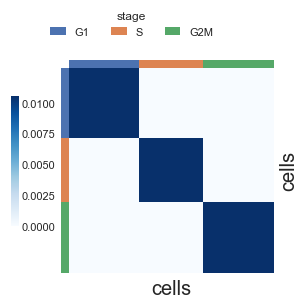

In [29]:
sft.plot_kernel(groupby="stage", 
                figsize=(size, size), 
                ncol=3, 
                interpolation=False, 
                fontsize=fontsize,
                # save_path=FIG_DIR / "cellcycle_virtualtumor" / "mESC_sim_subclones_map_kernel.png"
               )

In [30]:
sft.filter(
    embedding_key="X",
)

INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                


In [31]:
sc.pp.pca(adatas["SiFT (ground truth)"])

In [32]:
with io.capture_output() as captured:
    metrics_ = scib.metrics(
        adatas["Original"],
        adatas["SiFT (ground truth)"],
        batch_key= "stage",
        label_key="subcluster",
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=False,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=True,
        kBET_=True,
        ilisi_=True,
        clisi_=True,
        ).T

metrics_["data"] = "SiFT (ground truth)"

In [33]:
metrics = pd.concat((metrics, metrics_), ignore_index=True)

### SiFT (marker genes)

cell cycle genes for `S` and `G2M` are adapted from `Seurat`, [`cc.genes`](https://satijalab.org/seurat/reference/cc.genes.html), originaly taken from [[1]](https://www.science.org/doi/abs/10.1126/science.aad0501).

[[1] Tirosh, Itay, Benjamin Izar, Sanjay M. Prakadan, Marc H. Wadsworth, Daniel Treacy, John J. Trombetta, Asaf Rotem et al. "Dissecting the multicellular ecosystem of metastatic melanoma by single-cell RNA-seq." Science 352, no. 6282 (2016): 189-196.](https://www.science.org/doi/abs/10.1126/science.aad0501)

In [34]:
adatas["SiFT (cell cycle genes)"] = adatas["Original"].copy()

In [35]:
cell_cycle_genes = ['Mcm5',
 'Pcna',
 'Tyms',
 'Fen1',
 'Mcm7',
 'Mcm4',
 'Rrm1',
 'Ung',
 'Gins2',
 'Mcm6',
 'Cdca7',
 'Dtl',
 'Prim1',
 'Uhrf1',
 'Cenpu',
 'Hells',
 'Rfc2',
 'Polr1b',
 'Nasp',
 'Rad51ap1',
 'Gmnn',
 'Wdr76',
 'Slbp',
 'Ccne2',
 'Ubr7',
 'Pold3',
 'Msh2',
 'Atad2',
 'Rad51',
 'Rrm2',
 'Cdc45',
 'Cdc6',
 'Exo1',
 'Tipin',
 'Dscc1',
 'Blm',
 'Casp8ap2',
 'Usp1',
 'Clspn',
 'Pola1',
 'Chaf1b',
 'Mrpl36',
 'E2f8',
 'Hmgb2',
 'Cdk1',
 'Nusap1',
 'Ube2c',
 'Birc5',
 'Tpx2',
 'Top2a',
 'Ndc80',
 'Cks2',
 'Nuf2',
 'Cks1b',
 'Mki67',
 'Tmpo',
 'Cenpf',
 'Tacc3',
 'Pimreg',
 'Smc4',
 'Ccnb2',
 'Ckap2l',
 'Ckap2',
 'Aurkb',
 'Bub1',
 'Kif11',
 'Anp32e',
 'Tubb4b',
 'Gtse1',
 'Kif20b',
 'Hjurp',
 'Cdca3',
 'Jpt1',
 'Cdc20',
 'Ttk',
 'Cdc25c',
 'Kif2c',
 'Rangap1',
 'Ncapd2',
 'Dlgap5',
 'Cdca2',
 'Cdca8',
 'Ect2',
 'Kif23',
 'Hmmr',
 'Aurka',
 'Psrc1',
 'Anln',
 'Lbr',
 'Ckap5',
 'Cenpe',
 'Ctcf',
 'Nek2',
 'G2e3',
 'Gas2l3',
 'Cbx5',
 'Cenpa']

In [36]:
adatas["SiFT (cell cycle genes)"].obsm["cc_genes"] = adatas["SiFT (cell cycle genes)"][:, adatas["SiFT (cell cycle genes)"].var_names.isin(cell_cycle_genes)].X

In [37]:
sft =  sift.SiFT(
    adata=adatas["SiFT (cell cycle genes)"],
    kernel_key="cc_genes",
    metric="knn",
    n_neighbors=5,
    use_bbknn=False,
    copy=False,
)

INFO     sift: initialized a SiFTer with knn kernel.                                                               


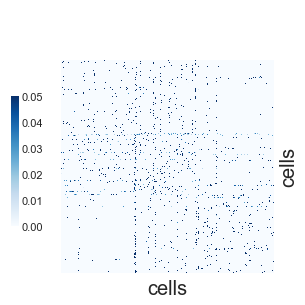

In [38]:
sft.plot_kernel( 
    figsize=(size, size), 
    interpolation=False,
    vmax=0.05,
    ncol=3,
    save_path=FIG_DIR / "cellcycle_virtualtumor"/ "mESC_sim_subclones_knn_cc_kernel.png"
)

In [39]:
sft.filter(
    embedding_key="X",
)

INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                


In [40]:
sc.pp.pca(adatas["SiFT (cell cycle genes)"])

In [41]:
with io.capture_output() as captured:
    metrics_ = scib.metrics(
        adatas["Original"],
        adatas["SiFT (cell cycle genes)"],
        batch_key= "stage",
        label_key="subcluster",
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=False,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=True,
        kBET_=True,
        ilisi_=True,
        clisi_=True,
        ).T

metrics_["data"] = "SiFT (cell cycle genes)"

In [42]:
metrics = pd.concat((metrics, metrics_), ignore_index=True)

### SiFT (Cyclum pseudotime binning)


In [43]:
adatas["SiFT (Cyclum, binned)"] = adatas["Original"].copy()
adatas["SiFT (Cyclum, binned)"].obs["pseudotime"] = psd

In [44]:
sft =  sift.SiFT(
    adata=adatas["SiFT (Cyclum, binned)"],
    kernel_key="pseudotime",
    metric="mapping",
    n_bins=12,
    copy=False,
    kernel_params = {"ignore_self":True}
)

INFO     sift: initialized a SiFTer with mapping kernel.                                                           


In [45]:
sft.adata.obs["bins"] =  sft.adata.uns["kernel"]["bins"]
sft.adata.obs["bins"] = sft.adata.obs["bins"].cat.rename_categories([str(i) for i in range(12)])

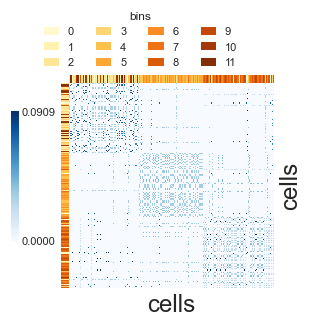

In [46]:
plot_kernel(
    kernel=sft.materialize_kernel(
                kernel_containers=sft._kernel_containers, to_cpu=True
            ),
    adata=sft.adata,
    src_key=sft._src_key,
    tgt_key=sft._tgt_key,
    groupby="bins",
    color_palette="YlOrBr",
    figsize=(size, size), 
    ncol=4, 
    interpolation=False,
    save_path= FIG_DIR / "cellcycle_virtualtumor"/ "mESC_sim_subclones_cyclum_nbin12_kernel.png"
)

In [47]:
sft.filter(
    embedding_key="X",
)

INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                


In [48]:
sc.pp.pca(adatas["SiFT (Cyclum, binned)"])

In [49]:
with io.capture_output() as captured:
    metrics_ = scib.metrics(
        adatas["Original"],
        adatas["SiFT (Cyclum, binned)"],
        batch_key= "stage",
        label_key="subcluster",
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=False,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=True,
        kBET_=True,
        ilisi_=True,
        clisi_=True,
        type_ = "full"
        ).T
    
metrics_["data"] = "SiFT (Cyclum, binned)"

In [50]:
metrics = pd.concat((metrics, metrics_), ignore_index=True)

In [51]:
metrics

,data,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,PCR_batch,cell_cycle_conservation,isolated_label_F1,isolated_label_silhouette,iLISI,cLISI,graph_conn,kBET,hvg_overlap,trajectory
0,original,0.210916,0.126226,0.513641,0.91173,0.0,1.0,0.660454,0.513641,0.412766,0.271847,NaN,NaN,NaN,NaN
1,Seurat,0.180692,0.107178,0.507892,0.911265,0.43657,0.556235,0.660454,0.507892,0.580238,0.169883,0.995495,NaN,0.078000,NaN
2,Cyclum,0.472286,0.488066,0.514691,0.926498,0.753227,0.985447,0.83469,0.514691,0.672416,0.185,1.000000,NaN,0.193333,NaN
3,ccRemover,0.074674,0.04306,0.501296,0.905598,0.442034,0.5719,0.660454,0.501296,0.659285,0.120494,0.977477,NaN,0.083333,NaN
4,SiFT (ground truth),0.495659,0.534126,0.5152,0.925354,1.0,1.0,0.855814,0.5152,0.829307,0.26775,NaN,NaN,NaN,NaN
5,SiFT (cell cycle genes),0.240209,0.25141,0.503324,0.973086,0.589523,0.57463,0.670979,0.503324,0.798355,0.197593,NaN,NaN,NaN,NaN
6,"SiFT (Cyclum, binned)",0.559734,0.647945,0.517284,0.903427,0.882006,0.87159,0.899783,0.517284,0.824124,0.465408,NaN,NaN,NaN,NaN


## Save data `all`

In [52]:
for adata in adatas.values():
    if "X_umap" in adata.obsm:
        del adata.obsm["X_umap"]
    if "umap" in adata.uns:
        del adata.uns["umap"]
    if "X_pca" in adata.obsm:
        del adata.obsm["X_pca"]
    if "pca" in adata.uns:
        del adata.uns["pca"]
    if "neighbors" in adata.uns:
        del adata.uns["neighbors"]
    if "louvain" in adata.uns:
        del adata.uns["louvain"]
    if "cluster" in adata.obs:
        del adata.obs["cluster"]


In [53]:
for adata in adatas.values():
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
with open(DATA_DIR / "cellcycle_virtualtumor"/ "adatas.pkl", "wb") as handle:
    pkl.dump(adatas, handle)

In [ ]:
metrics.to_pickle(DATA_DIR / "cellcycle_virtualtumor"/ "metrics.pkl")

## Load data `all`

In [ ]:
with open(DATA_DIR / "cellcycle_virtualtumor"/ "adatas.pkl" "rb") as handle:
    adatas = pkl.load(handle)

In [ ]:
metrics = pd.read_pickle(DATA_DIR / "cellcycle_virtualtumor"/ "metrics.pkl") 

## Transform metrics

In [54]:
metrics_ = metrics.drop(columns=["graph_conn","hvg_overlap", "trajectory", "kBET"])
metrics_["cell_cycle_conservation"] = 1-metrics_["cell_cycle_conservation"]
metrics_ = metrics_.rename(columns={"cell_cycle_conservation":"cell_cycle_removal"})

metrics_tr = metrics_.T

In [55]:
metrics_tr["score_type"] = ["None",
                            "bio conservation", 
                            "bio conservation", 
                            "bio conservation", 
                            "cell-cycle removal",
                            "cell-cycle removal",
                            "cell-cycle removal",
                            "bio conservation", 
                            "bio conservation", 
                            "cell-cycle removal",
                            "bio conservation", 
                           ]

In [56]:
bio_cons_mean = np.mean(metrics_.loc[:, metrics_tr["score_type"] == "bio conservation"], axis=1)
cc_mean = np.mean(metrics_.loc[:, metrics_tr["score_type"] == "cell-cycle removal"], axis=1)

bio_cons_var = stats.sem(metrics_.loc[:, metrics_tr["score_type"] == "bio conservation"].values.astype(float), axis=1)
cc_var = stats.sem(metrics_.loc[:, metrics_tr["score_type"] == "cell-cycle removal"].values.astype(float), axis=1)

In [57]:
metrics_["bio conservation (mean)"] = bio_cons_mean
metrics_["cell-cycle removal (mean)"] = cc_mean

metrics_["bio conservation (var)"] = bio_cons_var
metrics_["cell-cycle removal (var)"] = cc_var

In [58]:
method_colors = {
    "original": "#7C878EFF", 
    "Seurat":  "#FFCD00FF",
    "Cyclum":"#84BD00FF",  
    "ccRemover":"#CC0C00FF",
    "SiFT (ground truth)":  "#5C88DAFF", 
    "SiFT (cell cycle genes)": "#5C88DAFF", 
    "SiFT (Cyclum, binned)": "#5C88DAFF",
}

method_label = {
    "original": "Original data", 
    "ccRemover":"ccRemover",
    "Seurat": "Seurat", 
    "Cyclum":"Cyclum", 
    "SiFT (Cyclum, binned)": "SiFT (Cyclum, binned)",
    "SiFT (ground truth)":  "SiFT (ground truth)", 
    "SiFT (cell cycle genes)": "SiFT (cell cycle genes)",
}

method_hatches = {"original":"",
           "Seurat":"", 
           "Cyclum":"", 
           "ccRemover":"",
           "SiFT (Cyclum, binned)":".",
           "SiFT (ground truth)":"-",
           "SiFT (cell cycle genes)":"O",}

method_alpha = {"original":1,
           "Seurat":1, 
           "Cyclum":1, 
           "ccRemover":1,
           "SiFT (Cyclum, binned)":1,
           "SiFT (ground truth)":0.8,
           "SiFT (cell cycle genes)":0.6,}

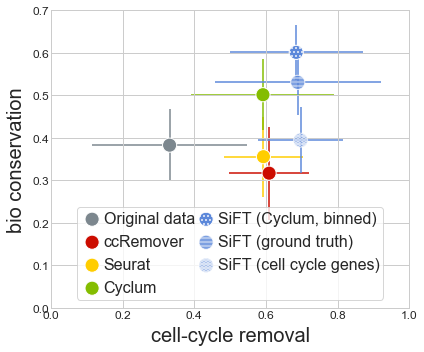

In [59]:
size = 5
fig, axs = plt.subplots(1, figsize=(size+1, size))

metrics_pl = metrics_[metrics_["data"].isin(method_colors.keys())]

for g in method_label:
    tmp = metrics_pl[metrics_pl["data"]==g]

    axs.errorbar(
        x=tmp["cell-cycle removal (mean)"], 
        y=tmp["bio conservation (mean)"], 
        xerr=tmp["cell-cycle removal (var)"], 
        yerr=tmp["bio conservation (var)"],fmt="none",
        ecolor=method_colors[g], elinewidth=1.5, capsize=0, zorder=0
    )
    axs.scatter(
        x=tmp["cell-cycle removal (mean)"], 
        y=tmp["bio conservation (mean)"], 
        label=method_label[g],
        hatch=3*method_hatches[g],
        facecolor=method_colors[g],
        color="white",
        alpha=method_alpha[g],
        s=200,
    )

plt.legend(fontsize=16, 
           ncol=2, 
           columnspacing=0, 
           handletextpad=0.02, 
           frameon=True,
           borderpad=0.26,
           borderaxespad=0.05,
           loc="lower center", 
           bbox_to_anchor=(0.5, 0.025))

plt.xlabel("cell-cycle removal", fontsize=20)
plt.ylabel("bio conservation", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,1])
plt.ylim([0, .7])
plt.tight_layout()
plt.savefig(FIG_DIR / "cellcycle_virtualtumor"/ "mESC_sim_subclones_scores.png", dpi=300, transparent=True)
plt.show()

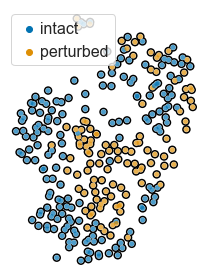

In [60]:
# plot the original data-set
size = 3
fig, axs = plt.subplots(1, figsize=(size, size+1))
pal = sns.color_palette("colorblind", 2)

sc.pl.umap(adatas["Original"], color="subcluster", add_outline=True,  
                   legend_fontsize=12, 
                   legend_fontoutline=1,
                   size=100,
                   frameon=False, 
                   title="sub-clones",
                   palette=pal,
                   show=False, ax=axs)
plt.legend(frameon=True, handletextpad=.02, loc="upper left", fontsize=16, bbox_to_anchor=(-0.02, 1))

plt.title("")
plt.tight_layout()
plt.savefig(FIG_DIR / "cellcycle_virtualtumor" / "mESC_sim_subclones_Original.png", dpi=DPI, transparent=True)
plt.show()
        

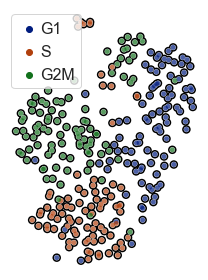

In [61]:
# plot the original data-set
size = 3
fig, axs = plt.subplots(1, figsize=(size, size+1))
pal = sns.color_palette("dark", 3)
# pal = sns.color_palette("Set2", 2)

sc.pl.umap(adatas["Original"], color="stage", add_outline=True, 
#             legend_loc="on data",
                   legend_fontsize=12, 
                   legend_fontoutline=1,
                   size=100,
                   frameon=False, 
                   title="cell-cycle stage",
                   palette=pal,
                   show=False, ax=axs)
plt.legend(frameon=True, handletextpad=.02, loc="upper left", fontsize=16, bbox_to_anchor=(-0.02, 1))
plt.title("")
plt.tight_layout()
plt.savefig(FIG_DIR / "cellcycle_virtualtumor" / "mESC_sim_subclones_Original_cell_cycle.png", dpi=DPI, transparent=True)
plt.show()
        

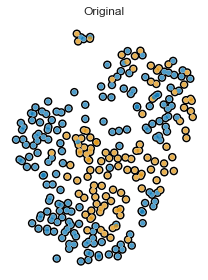

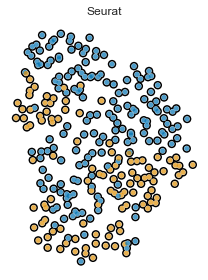

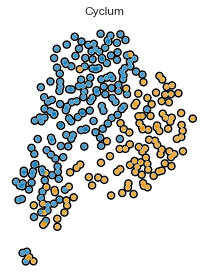

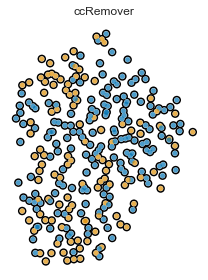

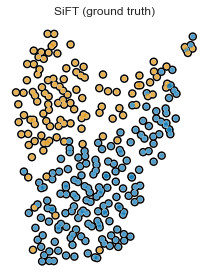

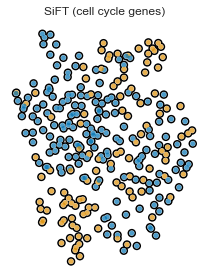

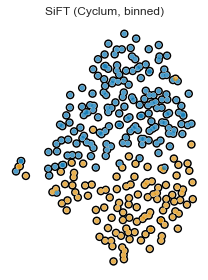

In [62]:
pal = sns.color_palette("colorblind", 2)

rows = 1
cols = 1
size = 3

for key, adata in adatas.items():
    fig, axs = plt.subplots(rows, cols, figsize=(size, size+1))
    sc.pl.umap(adata, color="subcluster", add_outline=True, 
                   size=100,
                   frameon=False, 
                   title=key, 
                   palette=pal,
                   show=False, ax=axs)
    axs.legend([])
    axs.set_title(key)
    plt.tight_layout()
    plt.savefig(FIG_DIR / "cellcycle_virtualtumor"/"mESC_sim_subclones_{}.png".format(key), dpi=DPI, transparent=True)
    plt.show()
        